# Bonus Module - Convolutional Neural Networks

Fully connected neural networks are great, but they are not a one size fits all solution. For instance, if we have a sequence of data, like text or sound, each data point has a context. If it's a sentence, then you need to know the preceding words to know the meaning of the current word. If it's sound, the current note may be part of a longer phrase which creates a melody. However, if we just use a fully connected neural network, we cannot use what has come before or after as context to the current input. In other words we can give it a single piece of the sequence with no context. For example, if I asked you what the word "for" means with no context, you would have a hard time. 

Recurrent neural networks are one way to handle sequential data. They are just like fully connected neural networks except they have looping connections. Loops allow the network to view the current input and state created from previous inputs as context. 

Another task fully connected networks struggle with is image recognition. Often, images have hundreds of thousands of pixels. Because we have to flatten all these pixels into a one dimensional list to feed them into a fully connected network, we need a ton of weights (more than one for each pixel). Not to mention the weights in subsequent hidden layers. In addition, since we flatten the image, we lose information about its structure which is inherently two dimensional. For example, if an image contains a face, we do not care where the face is or how many faces there are. Ideally, if we found some weights that can represent a face, we would not have to duplicate them for every part of the image. We could simply reuse the "face recognizer" over the entire image. This is where convolutional networks come in.

Convolutional networks solve the problem of efficiency and repetition when learning from images. Instead of connecting every pixel to a neuron, convolutional neural networks (CNN's) have a set of filters. A filter is just a matrix of weights (how important is each element). With one filter we can turn multiple pixel values into one number. We do this by overlaying the filter matrix on the image. Each element of the filter matrix "covers" one pixel. That pixel value is multiplied by the weight in the corresponding position of the filter. Once we multiply all the pixels "under" the filter we add them up and then add a bias. This process is very similar to our fully connected neuron wherein we multiply weights by inputs and add a bias. However, we are not done. The next step is to slide the filter over and repeat. When the filter reaches the furthest side of the image, it wraps down to the next row and continues. Because the filter turns multiple pixels into a single value, we end up with an "image" which is now smaller than the original. This resulting image is called a feature map because it maps the input image into a certain feature. For example, if we had an edge filter, the resulting feature map of that filter would have a high value (white) where an edge exists and a low value (black) where edges don't exist. The resulting image essentially looks like white lines drawn on a black sheet where each line is some edge in the original picture. Similarly, there may be a filter for detecting large areas of the same color. This filter may be useful in finding continuous surfaces that represent one object versus another. 

Filters are generally much smaller than the image, say a 5 X 5 matrix, and we may only have 10 or 20 of them. This significantly reduces the number of weights we need for the image. If we have an image of 100 X 100 pixels and we used a fully connected network, we would need 10,000 weights for every neuron in the first layer. However, with our filters we only need (5 X 5) X 20 = 500 weights for the first layer! This also solves the repetition problem because we take each filter and "slide" it across the entire image. In other words, if one filter learned to recognize faces, we could reuse that same filter for every face in the image.


# Convolution

In [87]:
import numpy as np


# a convolution operation involves multiplying
# the elements of a and b and summing them up 

a = np.array(
    [[1, 2, 3], 
     [4, 5, 6], 
     [7, 8, 9]])

b = np.array(
    [[9, 8, 7], 
     [6, 5, 4], 
     [3, 2, 1]])

np.sum(a * b)

165

# Sliding the filter across the image

In the example above, b can be considered the filter which we apply to a. However, the filter is often much smaller than the data it operates on. If the data is in image like in our case we expect the image to be much larger than 3x3. For the sake of simplicity we can make an "image" that is 10x10 and "slide" the filter b across it. 

<IPython.core.display.Javascript object>


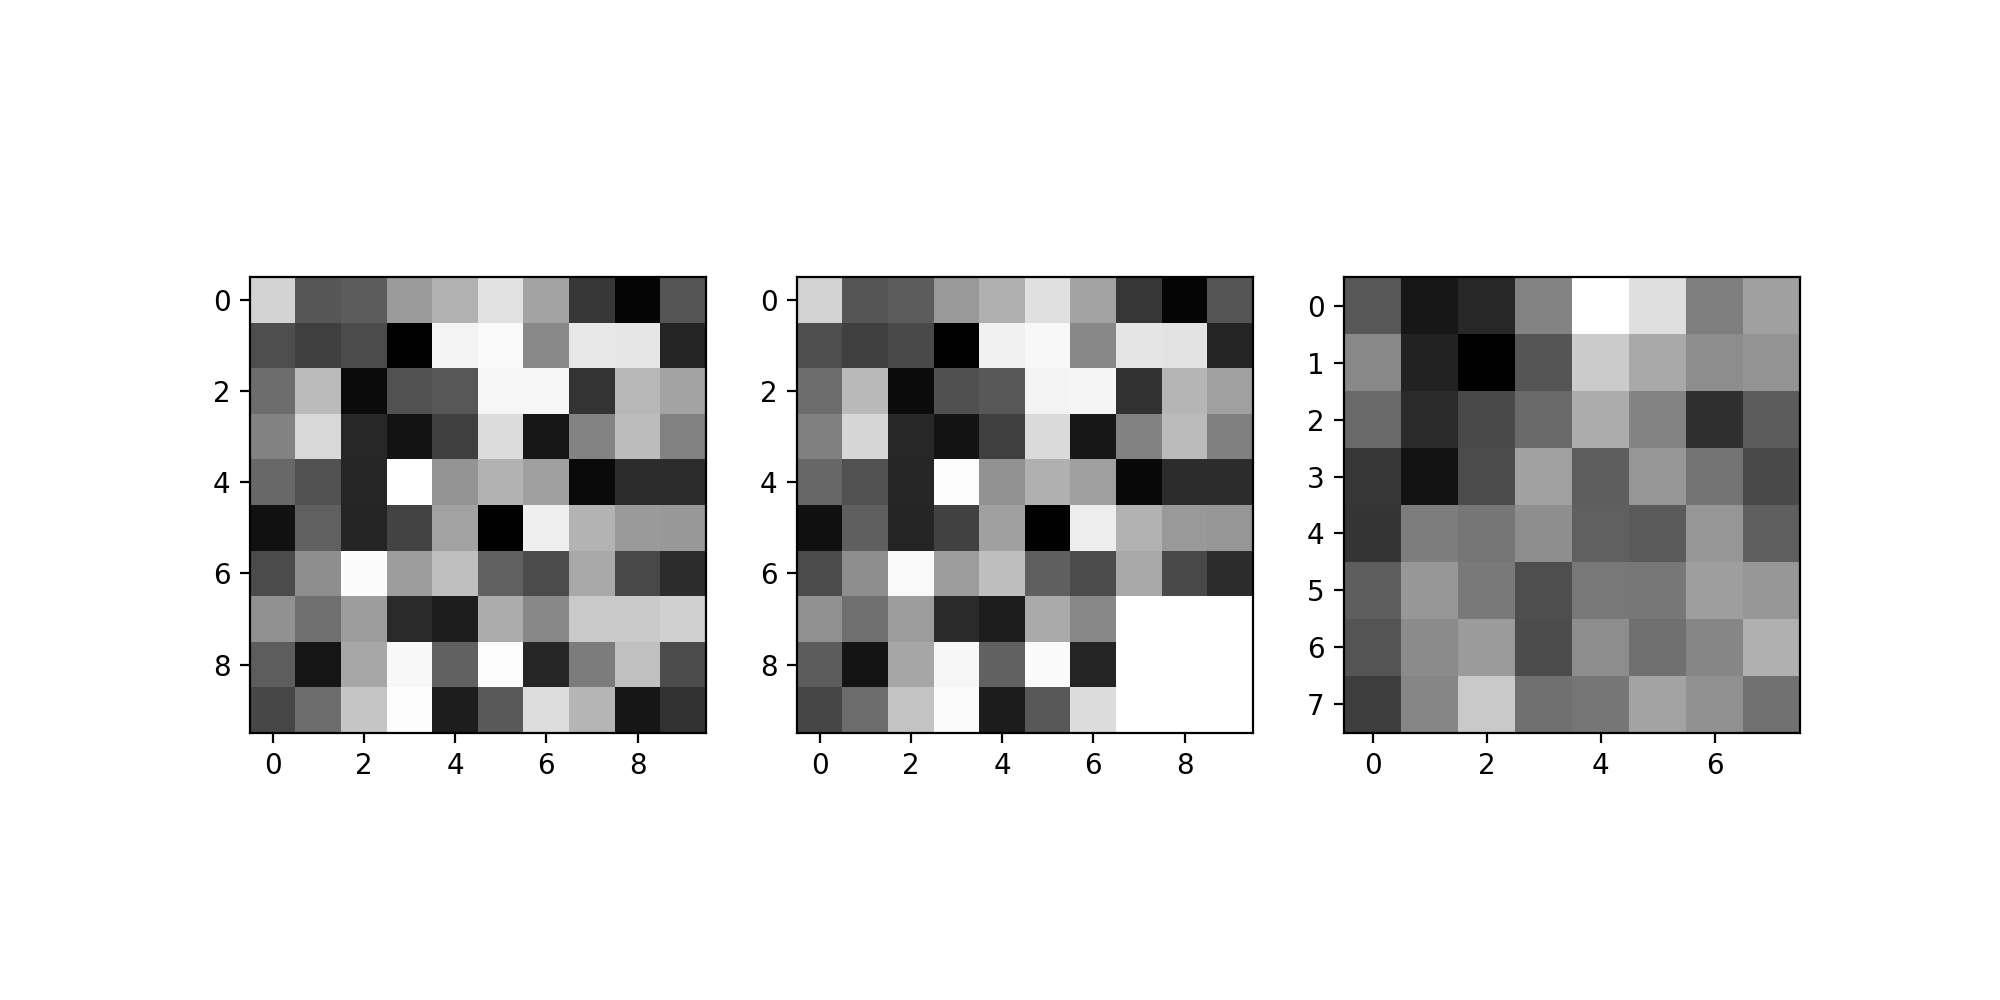

In [88]:
%matplotlib notebook
import time
import matplotlib.pyplot as plt

image = np.random.random(size=(10, 10))
f = np.random.random(size=(3, 3))

fig = plt.figure(figsize=(10, 5))
im_ax = fig.add_subplot(1,3,1)
slide_ax = fig.add_subplot(1,3,2)
fmap_ax = fig.add_subplot(1,3,3)

im_ax.imshow(image, cmap='gray')

x = image.shape[0] - f.shape[0] + 1
y = image.shape[1] - f.shape[1] + 1

feature_map = np.ones(shape=(x, y))

with_filter = np.copy(image)

for i in range(x):
    for j in range(y):
        # clear the axis to redraw
        slide_ax.clear()
        fmap_ax.clear()

        # show the filter at its current location on the image
        with_filter[i:(i + f.shape[0]), j:(j + f.shape[1])] = np.ones(shape=(3,3))

        # apply the convolution operation to the image and save the result
        feature_map[i, j] = np.sum(image[i:(i + f.shape[0]), j:(j + f.shape[1])] * f)

        # display the image with the filter overlay and the updated feature map
        slide_ax.imshow(with_filter, cmap='gray')
        fmap_ax.imshow(feature_map, cmap='gray')

        # reset the image copy to remove the filter
        with_filter[i:(i + f.shape[0]), j:(j + f.shape[1])] = image[i:(i + f.shape[0]), j:(j + f.shape[1])]

        fig.canvas.draw()
        plt.show()
        time.sleep(.2)

# Feature Extraction

We have seen how to slide a filter over an image and apply the convolution operation, but it didn't do anything useful. The whole point of the filter is to pickup on some pattern in the image like an edge or certain shape. When the filter actually does something useful we call it a feature extractor because it highlights something in the image. One such filter is for edge detection. If we use an actual image and this edge detection filter we can see how the edges are highlighted. In addition to the convolution operation, we apply an activation function to the feature map. 

<IPython.core.display.Javascript object>


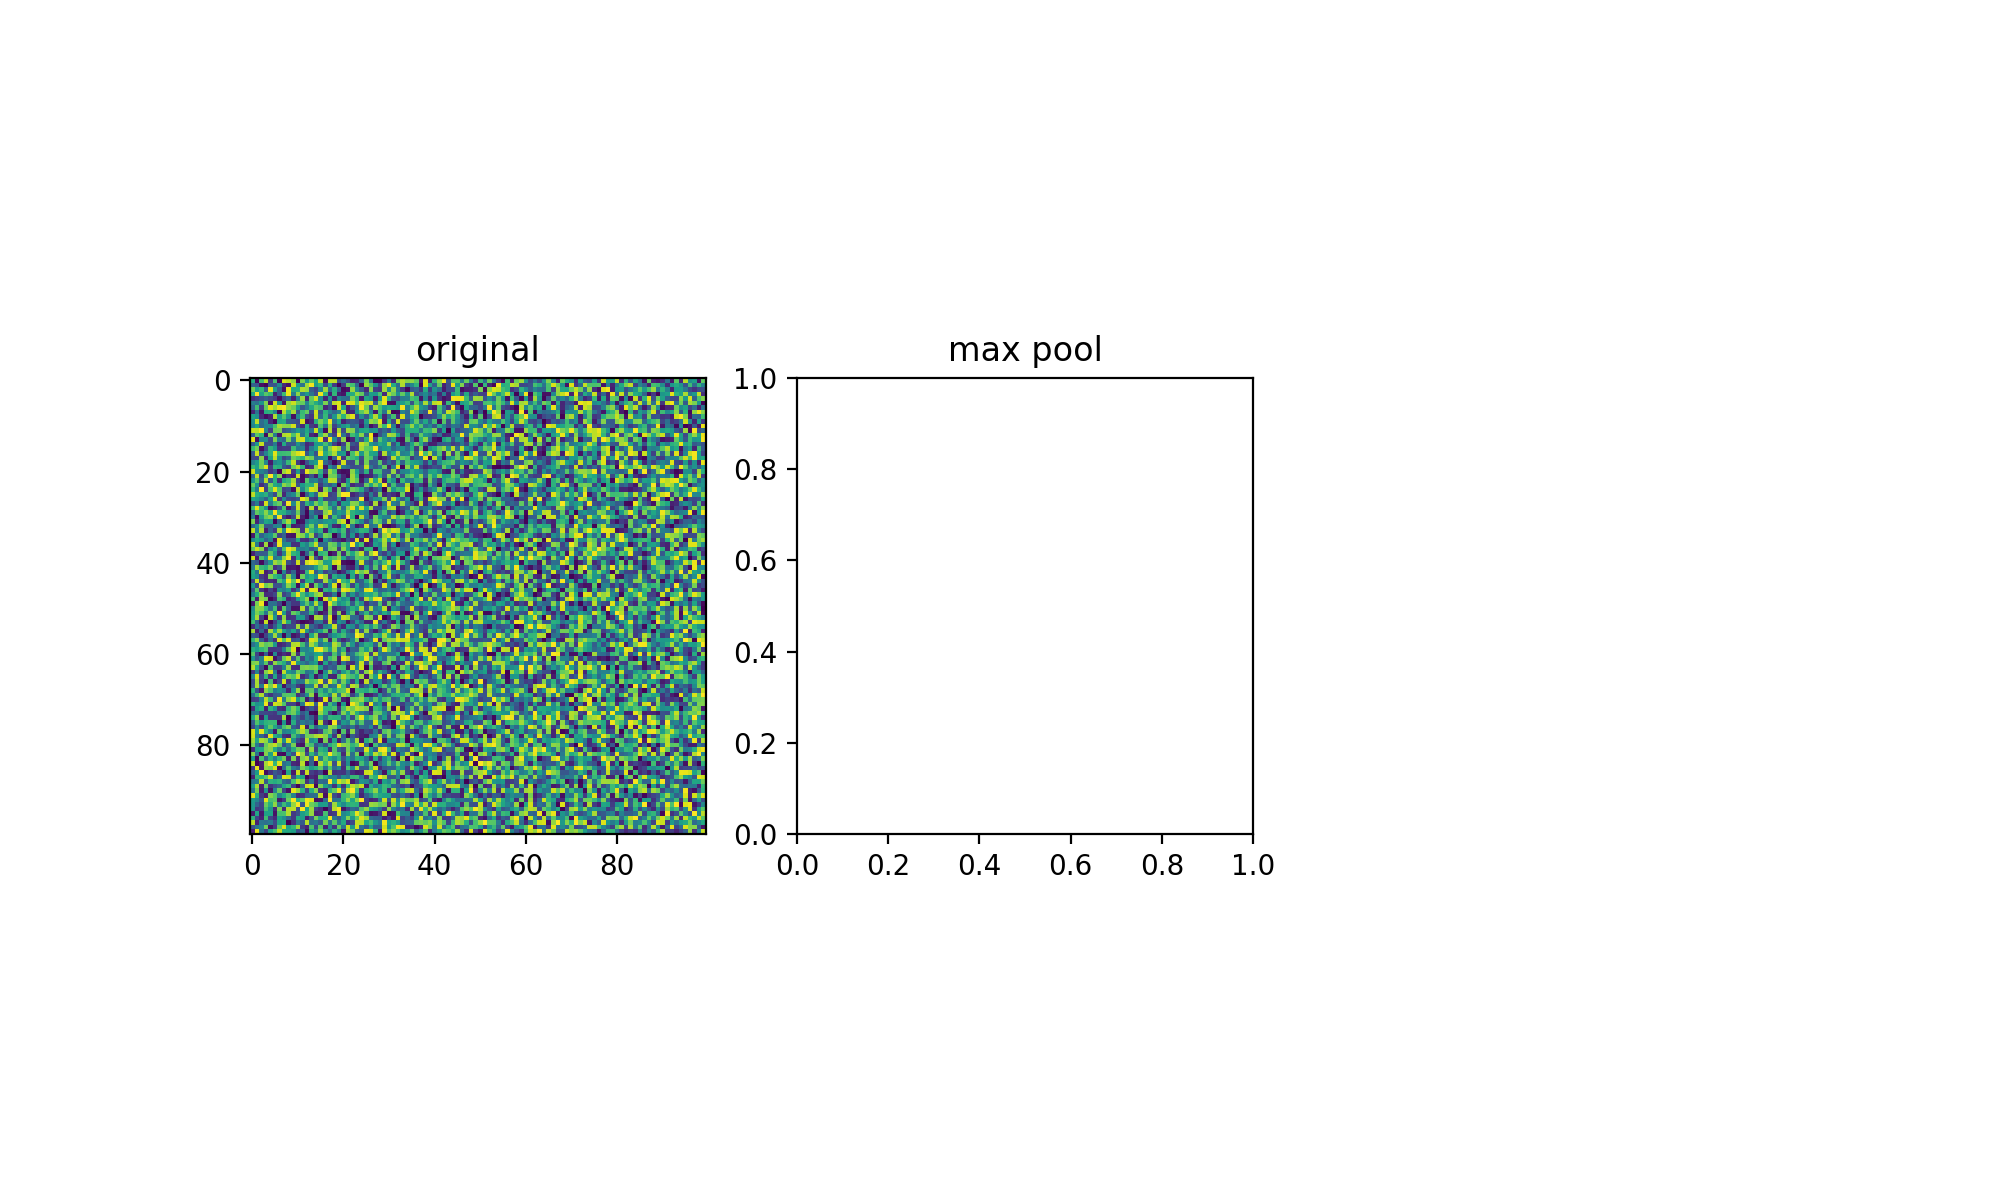

In [91]:
# lets import an image from the hand written digit dataset which contains a set of images of size 8 x 8
from PIL import Image
import requests
from io import BytesIO

# !!! PUPPY PIC !!!
url = 'https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/13001815/Alaskan-Malamute-On-White-03-400x267.jpg'
response = requests.get(url)
image = np.array(Image.open(BytesIO(response.content)))

# average the rgb values together to make a grayscale image
gray_img = np.mean(image, axis=2)

def relu(z):
    return max(0, z)


class ConvLayer:
    def __init__(self, f, activation=relu):
        self.f = f
        self.activation = activation
    
    def __call__(self, image):
        x = image.shape[0] - f.shape[0] + 1
        y = image.shape[1] - f.shape[1] + 1
        
        feature_map = np.ones(shape=(x, y))
        # slide the edge detection filter over the image
        # to create a feature map
        for i in range(x):
            for j in range(y):
                # convolution operation
                conv = np.sum(gray_img[i:(i + self.f.shape[0]),j:(j + self.f.shape[1])] * self.f)
                # activation function
                feature_map[i,j] = self.activation(conv)
                
        return feature_map

    
# edge detection filter
edge_filter = np.array(
    [[2, 4, -2],
     [4, 0, -4],
     [2, -4, -2]])

sharpen_filter = np.array(
    [[0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]])

blur_filter = np.array(
    [[0.0625, 0.125, 0.0625],
     [0.125,  0.25,  0.125],
     [0.0625, 0.125, 0.0625]])

# because we pass the edge detection filter into 
# our convolutional layer, we have created an edge detector
edge_detector = ConvLayer(edge_filter)
sharpener = ConvLayer(sharpen_filter)
blur = ConvLayer(blur_filter)

plt.figure(figsize=(10, 6))


plt.subplot(221)
plt.title('original')
plt.imshow(gray_img, cmap='gray')

plt.subplot(222)
plt.title('edge detection')
plt.imshow(edge_detector(gray_img), cmap='gray')

plt.subplot(223)
plt.title('sharpen')
plt.imshow(sharpener(gray_img), cmap='gray')

plt.subplot(224)
plt.title('blur')
plt.imshow(blur(gray_img), cmap='gray')

In [39]:
# ======================================= DOGS ============================================
# This is the section about dogs and how awesome they are!

# DOGS DOGS DOGS DOGS DOGS DOGS DOGS DOGS DOGS DOGS DOGS DOGS DOGS DOGS DOGS DOGS DOGS DOGS

# This is a dog matrix
np.array(
    [['dog', 'dog', 'dog'],
    ['dog', 'dog', 'dog'],
    ['dog', 'dog', 'dog']])

# there are endless types of dog data structures
# ======================================= DOGS ============================================

array([['dog', 'dog', 'dog'],
       ['dog', 'dog', 'dog'],
       ['dog', 'dog', 'dog']], dtype='<U3')

# Down Sampling

We have figured out how to pull certain features out of the images, but we still have a ton of pixels to deal with. After applying the filter, the image is a little smaller, but only by the size of the filter. Ultimately, we want to reduce the size of the image to less than a few hundred data points. Once the image is reduced to this size the idea is that only relevent information remains. In other words if we are trying to find road signs, the reduced vector would have elements that encode the presence of written text, sign shapes, certain colors, or any other information needed to decide if there's a sign. The reduced image is then fed through a fully connected neural network just like the one from the other modules. The fully connect network is then responsible for classifying the sign or whatever we want. 

In addition to applying filters to reduce the image size, we can combine multiple elements from the feature map into one. There are several ways to combine featue map elements. One is called max pooling. Using max pooling, we start off with a 2 dimensional area similar to the filter size for instance 2x2, 4x4, etc. We slide this 2 dimensional region, called a receptive field, across the feature map and only keep the maximum value of the current set of elements. After taking the max value, we slide the receptive field over just like the filter, and repeat. This entire operation is referred to as a pooling layer and is very common in convolutional neural network architecture. In addition to max pooling there is also average pooling, where instead of taking the max, we take the average. Average pooling is preferred to max pooling because information is lost when we simply throw values away. 

In [97]:
from statistics import mean

class PoolLayer:
    def __init__(self, pooler, dim):
        # a pooler is a function that takes in multiple values and returns one
        self.pooler = pooler
        # the dimensions of the receptive field to pool
        self.rec_field = dim
    
    def __call__(self, data):
        x = data.shape[0] - self.rec_field[0] + 1
        y = data.shape[1] - self.rec_field[1] + 1
        
        output = np.zeros(shape=(x, y))
        
        for i in range(x):
            for j in range(y):
                field = data[i:(i + self.rec_field[0]), j:(j + self.rec_field[1])]
                output[i,j] = self.pooler(field.flatten())
        
        return output
    

receptive_field = (10, 10)
img = np.random.random(size=(100, 100))

max_pooler = PoolLayer(max, receptive_field)
avg_pooler = PoolLayer(mean, receptive_field)

plt.subplot(131)
plt.title('original')
plt.imshow(img)

plt.subplot(132)
plt.title('max pool')
plt.imshow(max_pooler)

plt.subplot(133)
plt.title('average pool')
plt.imshow(avg_pooler)



/Users/haydenerickson/miniconda3/envs/nn-course/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


TypeError: Image data cannot be converted to float